## TSS : sxsx + h sz

In [46]:
%%time
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
from scipy.special import jn_zeros
from qutip import *
import matplotlib.pyplot as plt
from scipy.special import j0
from scipy.interpolate import make_interp_spline
from scipy.signal import savgol_filter    
from scipy.special import jn_zeros
freezing_pts = jn_zeros(0,5)

def drive(t, args):
    h0 = args['h0']
    h = args['h']
    w = args['omega']
    return h0 + h * np.cos(w * t)

def floq_evolv(args):
    N = args['N']
    T = 2 * np.pi/args['omega']
    opts = args['opts']
    sx,sy,sz= jmat(N,'x'),jmat(N,'y'),jmat(N,'z')
    
    H00 = 2/N*sx*sx
    H11 = 2 * sz
    H = [H00,[H11,drive]]
    
    f_states, f_modes = floquet_modes(H, T, args=args, sort=True)
    return f_states, f_modes

N = 5
nprocs = 2
omega = 90.0
w = omega
hss = w/4 * np.linspace(1, 16.0, 300)
hs = np.sort(np.concatenate((hss,  w/4 * freezing_pts)))

p = Pool(processes = nprocs)          
print("running for N = ", N, "with",nprocs,"processors")

opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=2)
params = [{'h0':np.pi/256, 'h':h, 'omega':omega, 'N':N, 'opts':opts} for h in hs]
data = p.map(floq_evolv,params)

print("running complete!")

running for N =  5 with 2 processors
running complete!
CPU times: user 148 ms, sys: 42.6 ms, total: 191 ms
Wall time: 6.36 s


In [49]:
iprmat = np.zeros((len(hs),2*N+1))
for xx,h in enumerate(hs):
    ft = np.array(data[xx][0])
    iprmat[xx,:] = [np.sum(np.abs(np.array(ft[i])) ** 4 ) for i in range(2*N+1)]

[0.99425946 0.99545481 0.99549628 0.99554932 0.99569367 0.99706217
 0.99710929 0.99851193 0.99852962 0.99937982 0.99938533]


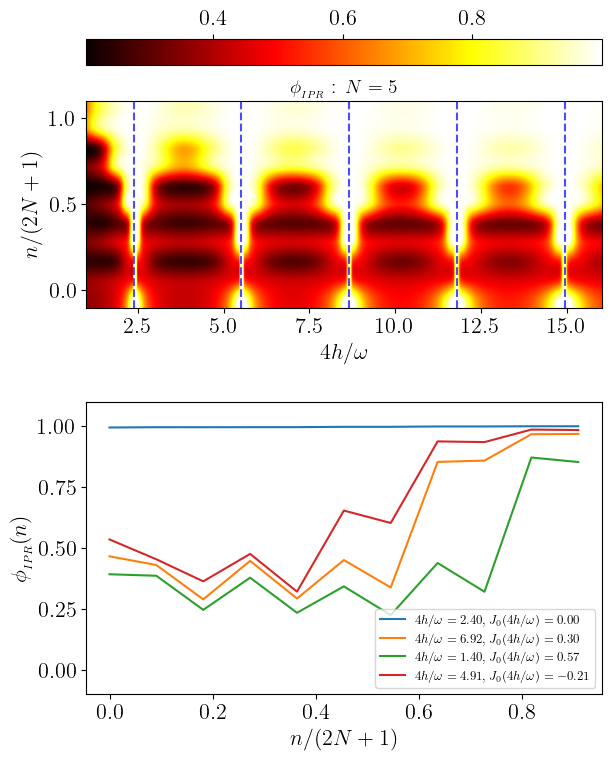

In [68]:
plt.rcParams.update({
    "figure.figsize": (6,7.5),
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 16,
    "font.sans-serif": ["Computer Modern"]})

etas = 4 * np.array(hs)/w

fig = plt.figure(constrained_layout=True)
ipr_ax, crosssec_ax = fig.subplots(2,1)

ipr_ax.set_title(fr'$\phi_{{_{{IPR}}}}$ : $N = {N}$', fontsize=14)
# find minimum of minima & maximum of maxima
minmin = np.min(np.min(iprmat))
maxmax = np.max(np.max(iprmat))
asp = 5
ipr_ax.set_xlabel(r'$4h/\omega$')
ipr_ax.set_ylabel(r'$n/(2N+1)$')

for pt in freezing_pts:
    ipr_ax.axvline(x=pt, color='blue', linestyle="--",linewidth=1.5, alpha =0.7)

im = ipr_ax.imshow(iprmat.T, aspect=asp, interpolation='spline16',\
                cmap='hot', origin='lower',extent = [etas[0] , etas[-1], -.1 , 1.1], vmax=maxmax, vmin=minmin)

fig.colorbar(im, ax=ipr_ax, location = 'top', shrink=1.0)

#Freezing point
idx, = np.where(np.isclose(etas, freezing_pts[0], atol=0.001))
n0 = idx[0]

#High IPR
idx, = np.where(np.isclose(etas, 7.0, atol=0.1))
n1 = idx[0]

#Intermediate IPR
idx, = np.where(np.isclose(etas, 1.5, atol=0.1))
n2 = idx[0]

#Another IPR
idx, = np.where(np.isclose(etas, 5.0, atol=0.1))
n3 = idx[0]

for i, n in enumerate([n0,n1, n2, n3]):
    xdata = np.arange(2*N+1)/(2*N+1)
    ydata =  iprmat[n]
    xnew = np.linspace(xdata.min(), xdata.max(), 1000)
    gfg = make_interp_spline(xdata, ydata, k=3)
    #crosssec_ax.plot(xnew, gfg(xnew), label=fr"$4h/\omega={etas[n]:1.2f}, J_0(4h/\omega)={j0(etas[n]):1.2f}$")
    crosssec_ax.plot(xdata, ydata, label=fr"$4h/\omega={etas[n]:1.2f}, J_0(4h/\omega)={j0(etas[n]):1.2f}$")

crosssec_ax.set_xlabel(r"$n/(2N+1)$")
crosssec_ax.set_ylabel(r"$\phi_{{_{{IPR}}}}(n)$")
crosssec_ax.set_ylim(-0.1, 1.1)
#crosssec_ax.axhline(y=1.0, linestyle ='--', color='black')
plt.legend(fontsize =9)

figname = "sxsxsz_tss.jpeg"
plt.savefig(figname,dpi=500)
plt.show()